In [2]:
!pip install pytorch-ignite

In [1]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pylab as plt


In [2]:
from train import load_model, get_dataloaders

In [3]:
# model_path = 'models/model_resnet50_2020-03-17 18.26.01.pth'
model_path = 'models/model_resnet50_2020-03-16 20.49.46.pth'
model_path = 'models/model_resnet50_2020-03-18 00.23.55.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [4]:
model = load_model(model_path)
model = model.to(device)

In [5]:
dataloaders, data = get_dataloaders(batch_size=50, shuffle=False)

In [6]:
def get_preds(model, dataloader):
    model.eval()
    all_preds = []
    all_probs = []
    for i, (samples, targets) in enumerate(dataloader):
        samples = samples.to(device)
        targets = targets.to(device)

        outputs = model(samples)
        output_softmax = torch.nn.Softmax()(outputs)
        # print(output_softmax.c)
        # break
        probs, preds = torch.max(output_softmax, 1)
        all_preds += list(preds.cpu().numpy())
        all_probs += list(probs.detach().cpu().numpy())
        # print(acc_multi, acc_bin)

    return all_preds, all_probs

In [14]:
def get_roc(preds_all, probs_all, targets, target, label):
    preds = (np.asarray(preds_all) != target).astype('int')
    probs = np.asarray(probs_all)
    probs_bin = np.abs(probs - (1 - preds))
    bin_target = (np.asarray(targets) != target).astype('int')
    print(roc_auc_score(bin_target, probs_bin))
    fpr, tpr, thresholds = roc_curve(bin_target, probs_bin)

    plt.plot(fpr, tpr, label=label)
    plt.legend()
    # plt.show()

In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
train, val, test = data

In [10]:
%%time
preds_all, probs_all = get_preds(model, dataloaders['test'])

Wall time: 41.9 s


In [11]:
targets = test[1]

In [12]:
confusion_matrix(targets, preds_all)

array([[3882,   64,   35,   15,   45,   65,  215],
       [  32,  608,   17,    1,    6,   15,   88],
       [  24,   10,  116,    1,    6,    4,   31],
       [  36,    9,    4,  151,    3,    5,   12],
       [  52,   10,    5,    3,  116,    5,   21],
       [ 113,   18,    6,   12,   22,  551,   71],
       [ 226,   98,   44,   10,   28,   38,  355]], dtype=int64)

In [29]:
def save_roc(preds_all, probs_all, targets, classes, filename='roc_auc.png'):
    # classes = np.asarray(classes)
    plt.title('ROC Curve')
    plt.grid()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    print('ROC AUC SCORE')
    for target, label in enumerate(classes):
        preds = (np.asarray(preds_all) != target).astype('int')
        probs = np.asarray(probs_all)
        probs_bin = np.abs(probs - (1 - preds))
        bin_target = (np.asarray(targets) != target).astype('int')
        print("\t {}: {:.4f}".format(label, roc_auc_score(bin_target, probs_bin)))
        fpr, tpr, thresholds = roc_curve(bin_target, probs_bin)

        plt.plot(fpr, tpr, label=label)
        plt.legend()
    
    # plt.savefig(filename)
    plt.show()

ROC AUC SCORE
	 good: 0.9171
	 celebrity: 0.9369
	 casino: 0.8909
	 guns: 0.9137
	 illegal: 0.8612
	 porno: 0.9199
	 yellow: 0.8118


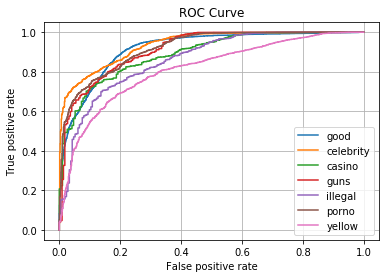

In [30]:
classes = np.array(['good', 'celebrity', 'casino', 'guns',
                'illegal', 'porno', 'yellow'])
save_roc(preds_all, probs_all, targets, classes)
# # classes = np.array(['good', 'porno', 'yellow'])
# for i, cl in enumerate(classes):
#     print(cl)
#     get_roc(preds_all, probs_all, targets, i, cl)

In [14]:
from sklearn.utils.multiclass import unique_labels

In [51]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    classes = np.asarray(classes)
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

#     # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('test_conf.png')

Normalized confusion matrix
[[0.89840315 0.01481139 0.00809998 0.00347142 0.01041426 0.01504281
  0.049757  ]
 [0.04172099 0.79269883 0.02216428 0.00130378 0.00782269 0.01955671
  0.11473272]
 [0.125      0.05208333 0.60416667 0.00520833 0.03125    0.02083333
  0.16145833]
 [0.16363636 0.04090909 0.01818182 0.68636364 0.01363636 0.02272727
  0.05454545]
 [0.24528302 0.04716981 0.02358491 0.01415094 0.54716981 0.02358491
  0.0990566 ]
 [0.14249685 0.02269861 0.0075662  0.01513241 0.02774275 0.69482976
  0.08953342]
 [0.28285357 0.12265332 0.05506884 0.01251564 0.0350438  0.04755945
  0.44430538]]


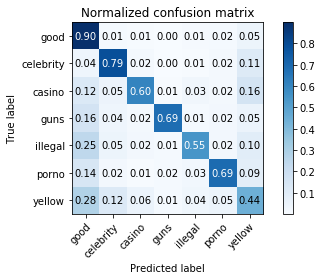

In [52]:
plot_confusion_matrix(targets, preds_all, classes, normalize=True)

In [46]:
%matplotlib inline

In [71]:
preds = (np.asarray(preds_all) != targ).astype('int')
preds[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [72]:
1 - preds

array([0, 0, 0, ..., 0, 1, 0])

In [73]:
probs = np.asarray(probs_all)
probs[:10]

array([0.93188274, 0.88308537, 0.87388617, 0.57936686, 0.4747552 ,
       0.91028106, 0.9861902 , 0.99921465, 0.9773762 , 0.6835075 ],
      dtype=float32)

In [74]:
probs_bin = np.abs(probs - (1 - preds))
probs_bin[:10]

array([0.93188274, 0.88308537, 0.87388617, 0.57936686, 0.4747552 ,
       0.91028106, 0.9861902 , 0.99921465, 0.97737622, 0.6835075 ])

In [75]:
bin_target = (np.asarray(test[1]) != targ).astype('int')
bin_target[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [57]:
from sklearn.metrics import roc_auc_score, roc_curve

In [76]:
roc_auc_score(bin_target, probs_bin)

0.9481824483450239

In [77]:
fpr, tpr, thresholds = roc_curve(bin_target, probs_bin)

In [78]:
import matplotlib.pylab as plt

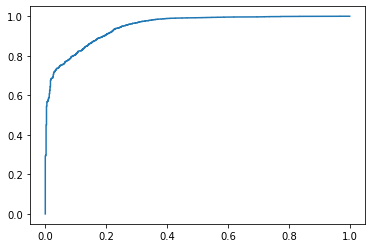

In [79]:
plt.plot(fpr, tpr)

In [90]:

class CombineLoss(torch.nn.Module):
    def __init__(self, alpha=0.5, classes=8):
        super(CombineLoss, self).__init__()
        self.alpha = alpha

    def forward(self, outputs, targets):
        bin_targets = (targets != 0).long()
        # bin_targets = bin_targets.to(targets.device)

        bin_outputs = F.softmax(outputs)
        bin_outputs = torch.stack((bin_outputs[:, 0], bin_outputs[:, 1:].sum(axis=1)), dim=-1)
        # assert bin_outputs.shape == bin_targets.shape
        return self.alpha * F.cross_entropy(bin_outputs, bin_targets) + (1 - self.alpha) * F.cross_entropy(outputs, targets)



In [91]:
import torch
import numpy as np
import torch.nn.functional as F


In [92]:
aa = torch.zeros(2, 8)
aa[0, 0] = 1
aa[1, :] = 1 - aa[0, :]

In [93]:
targets = torch.as_tensor(np.random.randint(4, size=(10)))
targets

tensor([3, 3, 3, 2, 2, 1, 1, 2, 1, 3], dtype=torch.int32)

In [96]:
aa[(targets != 0).long()]

tensor([[0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.]])

In [97]:
vec = torch.as_tensor(np.random.rand(10, 8))
targets = torch.as_tensor(np.random.randint(4, size=(10)), dtype=torch.int64)

In [100]:
CombineLoss()(vec, targets) 

tensor(1.3818, dtype=torch.float64)

In [21]:
sm = torch.nn.Softmax()(vec)

In [32]:
bad = sm[:, 1:].sum(axis=1)

In [37]:
torch.stack((sm[:, 0], bad), dim=-1)

tensor([[0.2508, 0.7492],
        [0.1456, 0.8544],
        [0.2899, 0.7101]], dtype=torch.float64)

In [1]:
import torch
model_path = 'models/model_resnet50_2020-04-18 16.58.28.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [6]:
import pandas as pd 
from PIL import Image
from os import path
import os
from train import get_dataloaders, load_model
from utils.data import get_preds
import torch

BASE_DIR = 'data_new'

def get_misplased(model, classes):
    dataloaders, (train, val, test) = get_dataloaders(batch_size=50, shuffle=False, classes=classes, base_dir=BASE_DIR)
    all_preds, _ = get_preds(model, dataloaders['test'], device)
    df = pd.DataFrame({"file": test[0], "target": test[1], "preds": all_preds})
    df_bad = df[(df['target'] != df['preds'])]
    misplased_save(df_bad, classes)

def misplased_save(df, classes):
    for class_num, class_val in enumerate(classes):
        misplaced = df[df['target'] == class_num]        
        dir_misplased = 'data_new_misplaced/' + class_val

        if not os.path.exists(dir_misplased):
            os.makedirs(dir_misplased)
        
        for ind, (filename, tar, pred) in misplaced.iterrows():
            Image.open(filename).save(path.join(dir_misplased, '{}_{}.png'.format(ind, classes[pred])))



In [4]:
model_path = 'models/model_resnet50_2020-04-18 16.58.28.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model = load_model(model_path)
model = model.to(device)

In [7]:
classes = ['good', 'celeb', 'casino', 'guns',
                'illegal', 'narco', 'porno', 'yellow']
get_misplased(model, classes)

NameError: name 'results' is not defined

In [1]:
from cls_models import get_model

In [2]:
model = get_model('dense121')

In [1]:
# model

In [16]:
len(list(model.features.denseblock4.parameters()))

96

In [1]:
from train import get_dataloaders

In [12]:
classes = ['good', 'celeb', 'casino', 'guns',
            'illegal', 'narco', 'porno', 'yellow']

dataloders, (train, val, test) = get_dataloaders(batch_size=10, base_dir='data_new', classes=classes)

In [13]:
from collections import Counter
import numpy as np
narco = list(np.array(train[0])[np.array(train[1]) == 5])
train = (train[0] + narco, train[1] + [5] * len(narco))
Counter(train[1])

Counter({7: 30561,
         6: 12617,
         0: 43200,
         1: 8357,
         3: 3226,
         2: 3916,
         4: 2653,
         5: 2034})

In [6]:
import numpy as np

np.random.choice(50, size=5)

array([19, 24,  9, 49, 33])

In [5]:
img, trg = next(iter(dataloders['train']))

In [6]:
model(img).shape

torch.Size([10, 8])

In [9]:
len(list(model.parameters()))

364

In [20]:
img.shape

torch.Size([10, 3, 224, 224])

In [1]:
import torchvision
dense = torchvision.models.densenet121(pretrained=True)

In [24]:
vgg16.avgpool(vgg16.features(img)).shape

torch.Size([10, 512, 7, 7])

In [7]:
%%time
dense(img).shape

Wall time: 2.59 s


torch.Size([10, 1000])

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [1]:
import torchvision
dense = torchvision.models.resnet50(pretrained=False)

In [10]:
list(dense.children())[4:8]

[Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2):